# PCA and PPCA
## COMP9417-17s1, W13 Tutorial, Exercise 2
### Instructor: Edwin V. Bonilla
#### School of Computer Science and Engineering, UNSW Sydney 

In this section we will further explore the concepts in Principal Component Analysis (**PCA**) and Probabilistic Principal Component Analysis (**PPCA**). You are provided with the data file *usps\_ppca.mat* which contains the variable _x2tr_,  _x3tr_ and   _xte_. The main goal of this exercise is to understand how to fit (estimate) a PPCA model for dimensionality reduction and how to use it for classification following a probabilistic class-conditional modelling approach.

We first define a few useful functions and imports that we will use later on:

In [1]:
import numpy as np
import scipy.io as sio
%matplotlib inline 
import matplotlib.pyplot as pl

def plot_image(array, dim=16):
    """
    Plot array as an image of dimensions dim * dim
    """
    img = array.reshape(dim,dim, order = "F")
    pl.imshow(img, cmap=pl.cm.gray)
    ax = pl.gca();ax.set_yticks([]);ax.set_xticks([])
    
def get_eigenspectrum(x):
    """
    Get the eigenspectrum of the covariance of x.
    :param x: (N,D)-dimensional array 
    :return l: 1-dimensional array of ordered eigenvalues
    :return E: (N,N)-dimensional array of corresponing eigenvectors, 
        where each column is an eigenvector
    :return p: 1-dimensional array with cumulative variances 
    """
    S = np.cov(x, rowvar=False)
    l, E = np.linalg.eig(S)
    idx = np.argsort(l)[::-1]
    l = l[idx]
    E = E[:,idx]
    p = l / np.sum(l)
    p = np.cumsum(p)
    return l, E, p

For historical reasons these data are in matlab format, so we proceed to loading them using _loadmat_ from scipy:

In [2]:
data = sio.loadmat('usps_ppca.mat')
x2tr = data['x2tr']
x3tr = data['x3tr']
xte = data['xte']

The arrays above are $N \times D$ matrices whose rows correspond to vectorial representations of the digits 2 and 3, where $N$ is the number of datapoints and  $D=256$ is the dimensionality of the vectors. We then check their dimensions:

In [3]:
N2_tr, D2_tr = x2tr.shape
N3_tr, D3_tr = x3tr.shape
N_te, D_te = xte.shape
print("Number of training points for class 2 = " + repr(N2_tr) )
print("Number of training points for class 3 = " + repr(N3_tr) )
print("Number of test points = " + repr(N_te) )
print("Dimensionality of the inputs = " + repr(D2_tr) )  # This should be the same for all arrays


Number of training points for class 2 = 500
Number of training points for class 3 = 500
Number of test points = 600
Dimensionality of the inputs = 256


We can transform one of these vectors, say the 5th row of _x2tr_ into a $16 \times 16$ grayscale image using:

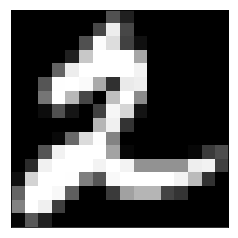

In [4]:
plot_image(x2tr[4,:])

## Exercise 1

Compute the mean of the $2$s dataset (_x2tr_) and visualize its grayscale image.

## Exercise 2

Using the function `get_eigenspectrum(x)` defined above, Get the eigenspectrum _l2, E2, p2_ of _x2tr_ and plot the top 4 eigenvectors. What variability is explained by each of these egeinvectors? 

## Exercise 3

Plot the cumulative variance _p2_. What do you think the intrinsic dimensionality of these data is? How many components are required to explain at least $95\%$ of the variance?

## Exercise 4

Recall that the ML estimates of the PPCA parameters are: $\boldsymbol{\mu}_{\text{ML}} = \bar{\mathbf{x}}; \quad \mathbf{W}_{\text{ML}} = \mathbf{E} (\mathbf{\Lambda} - \sigma_{\text{ML}}^2 \mathbf{I})^{1/2} \mathbf{R}; \quad \sigma_{\text{ML}}^2 = \frac{1}{D-K} \sum_{i=K+1}^D \lambda_i$; where $D$ is the original input dimensionality; $K$ is the reduced dimensionality; $\bar{\mathbf{x}}$ is the sample mean; $\{ \lambda_i \}$ are the ordered eigenvalues of the data covariance; $\mathbf{\Lambda}$ is a diagonal matrix with $\{\lambda_i\}$ on its diagonal; $\mathbf{E}$ is the matrix with corresponding eigenvectors on the columns; and $\mathbf{R}$ is an arbitrary rotation matrix.

Using $K=3$ and $\mathbf{R} = \mathbf{I}$, fit a PPCA model to _x2tr_ and _x3tr_ using maximum likelihood. Note that for _x2tr_ you have already computed the eigenspectrum. Name the corresponding variables _mu2_, _W2_, _var2_ and _mu3_, _W3_,  _var3_.

## Exercise 4

We know that the marginal distribution $p(\mathbf{x})$ of the PPCA model is given by: $p(\mathbf{x}) = \mathcal{N} (\mathbf{x}; \boldsymbol{\mu}, \mathbf{C})$, where $\boldsymbol{\mu}$ is the mean of the PPCA model and $\mathbf{C} = \mathbf{W} \mathbf{W}^T + \sigma^2 \mathbf{I}$. In order to compute the log probability of a single datapoint $\mathbf{x}$ we then need to evaluate the log probability of the Gaussian above, which is given by: $\log p(\mathbf{x}) = - \frac{1}{2} \left[ \log | \mathbf{C} | + D  \log 2 \pi + (\mathbf{x} - \boldsymbol{\mu})^T \mathbf{C}^{-1} (\mathbf{x}-\boldsymbol\mu) \right]$. This involves the computaion of the determinant and the inverse of the covariance matrix $\mathbf{C}$, which can be computed using: $\mathbf{C}^{-1} = \sigma^{-1} \mathbf{I} - \sigma^{-2} \mathbf{W} \mathbf{M}^{-1} \mathbf{W}^T$ with $\mathbf{M} = \mathbf{W}^T \mathbf{W} + \sigma^2 \mathbf{I}$; and $\log |\mathbf{C}| = \sum_{k=1}^{K} \log \lambda_k + (D-K) \log \sigma^2$.

***(a)*** Why is computing the inverse above more efficient than computing to the inverse of $\mathbf{C}$ directly according to its definition?

***(b)*** What is the intuition of the expression for  $\log |\mathbf{C}|$?

## Exercise 5

The function below computes the log probability of a datapoint _x_ under a PPCA model.

In [147]:
def logprob_PPCA(l, mu, W, var, x):
    """
    Compute the log probability of a point x under a PPCA model.
    @param l: Selected K eigenvalues of the PPCA model
    @param mu: mean of the PPCA model
    @param W: (D,K)-dimensional array of weights of PPCA model
    @param var: Variance of the PPCA model
    @param x: Test point to compute the log probability under the model
    """
    xtilde = x - mu
    D, K = W.shape
    Ik = np.eye(K)
    Id = np.eye(D)
    Wt = np.transpose(W)
    M = np.dot(Wt,W) + var * Ik
    Minv = np.linalg.inv(M)
    Cinv = (1.0/np.sqrt(var))*Id - (1.0/var)*np.dot(W, np.dot(Minv, Wt)) 
    quad_term = np.sum(xtilde * np.dot(Cinv, xtilde))
    logdet = np.sum(np.log(l)) + (D-K) * np.log(var)
    logprob = - 0.5 * (logdet + D * np.log(2*np.pi) + quad_term)
    return logprob
    

***(a)*** Compute the log probability of each test datapoint in _xte_ under each of the PPCA models for 2s and 3s. Use these log probabilities to classify the test datapoints as a '2' or a '3' and count the number of points classified on each class. Make a bar plot of the resulting counts. 

***(b)*** Make an image plot of the mean of _xte_ and compare this to the results obtained in the previous item.